In [1]:
import gym
import gym_stock_exchange
import random
import numpy as np
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('game-stock-exchange-v0')

In [2]:
from functools import partial
from copy import deepcopy
import datetime
from itertools import count
import math
import logging
import matplotlib.pyplot as plt
import numpy as np
from random import choice
import time
from utils import device, train_dqn
import seaborn as sns
from collections import deque

In [3]:
from utils import ReplayMemory
import torch.optim as optim

In [11]:
FEATURES = 512
class DuelingDQN(nn.Module):
    # Eventually, n_tickers should create n number of values and advantages
    def __init__(self, n_input_features, n_action_space, n_tickers=None):
        super(DuelingDQN, self).__init__()
        self.n_action_space = n_action_space
        self.feature = nn.Sequential(
            nn.Linear(n_input_features, FEATURES),
            nn.ReLU(),
            nn.Linear(FEATURES, FEATURES),
            nn.ReLU(),
            nn.Linear(FEATURES, FEATURES),
            nn.ReLU(),
        )

        self.value = nn.Sequential(
            nn.Linear(FEATURES, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        self.advantage = nn.Sequential(
            nn.Linear(FEATURES, 32),
            nn.ReLU(),
            nn.Linear(32, n_action_space)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value(x)
        advantage = self.advantage(x)
        return value + advantage - advantage.mean()

    def predict(self, x):
        return self.forward(x).detach().sort(dim=1, descending=True)

    def act(self, x, epsilon):
        if not torch.is_tensor(x):
            x = torch.tensor([x], dtype=torch.float32, device=device)
        if np.random.rand() > epsilon:
            x = self.feature(x).detach()
            x = self.advantage(x).detach().argmax().item()
            return x
        else:
            return np.random.randint(self.n_action_space)

1000    2017-12-20
1001    2017-12-21
1002    2017-12-22
1003    2017-12-26
1004    2017-12-27
Name: date, dtype: object

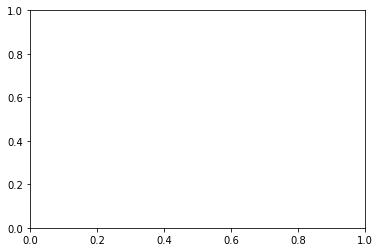

In [10]:
env.create_engine('aapl', '2014-01-01', 1000, num_action_space=5)
env.env.tickers[0].dates[1000:].head()

In [14]:
def get_running_state(num_days):
    return np.zeros(num_days).tolist()

def add_new_state(running_state_orig, new_state_to_add):
    if isinstance(new_state_to_add, list):
        new_state_to_add = new_state_to_add[0]
        
    running_state = pd.Series(running_state_orig).shift(-1)
    
    # Assign new price to index == last_elem - 1
    running_state.iloc[-2] = new_state_to_add.item(0)
    # Assign new position to index == last_elem
    running_state.iloc[-1] = new_state_to_add.item(1)
    
    assert len(running_state_orig) == len(running_state)
    
    return running_state.tolist()

In [13]:
from IPython.display import clear_output
def plot(frame_idx, rewards, losses, eps):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s eps: %s' % (frame_idx, np.mean(rewards[-10:]), eps))
    plt.scatter(np.arange(len(rewards)), rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

Since 1000th day was 2017-12-20, let's start testing with the market data from 2018-01-01

95    2018-05-18
96    2018-05-21
97    2018-05-22
98    2018-05-23
99    2018-05-24
Name: date, dtype: object

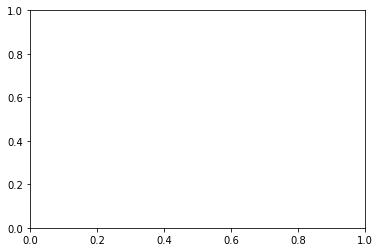

In [19]:
env.create_engine('aapl', '2018-01-01', 100, num_action_space=5)
env.env.tickers[0].dates[:100].tail()

In [15]:
# Actual days will be 19 days, plus one spot for position variable
NUM_RUNNING_DAYS = 20

In [25]:
def test_exchange(env, policy_q, testing_interval=100):
    running_state = get_running_state(NUM_RUNNING_DAYS)
    
    state = env.reset()
    running_state = add_new_state(running_state, state)

    for _ in range(NUM_RUNNING_DAYS-1):
        # recall step 2 makes position unchanged given 
        # action_space == 5
        next_state, reward, done, _ = env.step(2)
        running_state = add_new_state(running_state, next_state)
        
        assert reward == 0, \
                f'Reward is somehow {reward}'
        assert running_state[-1] == 0.0, \
                f'Position is somehow {running_state[-1]}'
        
    episode_rewards = []
    
    for _ in range(testing_interval):
        action = policy_q.act(running_state, 0.0)
        
        next_state, reward, done, _ = env.step(action)

        # update running_state for the next use
        running_state = add_new_state(running_state, next_state)
        episode_rewards += [reward]
    
    return episode_rewards

In [21]:
policy_q, target_q = DuelingDQN(NUM_RUNNING_DAYS, 5).cuda(), \
                        DuelingDQN(NUM_RUNNING_DAYS, 5).cuda()

In [22]:
try:
    policy_q.load_state_dict(torch.load('my_duel_policy_vanila.pt'))
    target_q.load_state_dict(torch.load('my_duel_target_vanila.pt'))
except FileNotFoundError:
    print('--- Files Not Found ---')

In [28]:
len(rewards)

100

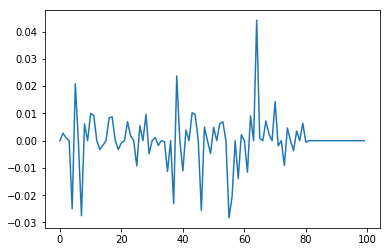

In [32]:
rewards = test_exchange(env, policy_q)
plt.plot(rewards)

In [33]:
sum(rewards)

0.01448858238587164